# House Data Analysis - Fortaleza/CE Brazil

## 1. Importing packages

In [59]:
import requests
import pandas as pd
from pandas_profiling import ProfileReport
import time
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pycep_correios
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy import stats
from scipy.stats import norm
import warnings
import math
warnings.filterwarnings('ignore')

## 2. Loading the data from CSV File

### 2.1 Loading the data using pandas and creating a DataFrame

In [2]:
df_Properties = pd.read_csv('./Resources/olx_Fortaleza_220830.csv')


### 2.2 Looking how our dataset looks like 
 

In [3]:
df_Properties.head()

,Category,Type,Cond_Price,IPTU_Price,Area,Bedrooms,Bathrooms,Garage,Property_Detail,Cond_Detail,Price,Zipcode,City,Neighboor,Address,Description
0,Apartamentos,Venda - apartamento padrão,R$ 790,R$ 1.200,110m²,3,4,2,"Mobiliado, Piscina, Ar condicionado, Varanda, ...","Salão de festas, Condomínio fechado, Permitido...",R$ 690.000,60110370,Fortaleza,Meireles,Rua Antônio Augusto - até 909/910,Código do anúncio: LC0013\n\nConheça o Marbell...
1,Apartamentos,Venda - apartamento padrão,R$ 0,R$ 0,54m²,2,2,2,"Churrasqueira, Piscina, Ar condicionado","Piscina, Elevador",R$ 499.000,60812260,Fortaleza,Edson Queiroz,Travessa Contaneide,Código do anúncio: AP0389\n\nEmpreendimento es...
2,Apartamentos,Venda - apartamento padrão,R$ 450,R$ 0,82m²,3,3,2,"Churrasqueira, Área de serviço, Piscina","Piscina, Elevador",R$ 650.000,60810220,Fortaleza,Engenheiro Luciano Cavalcante,Rua Gontran Giffoni,Código do anúncio: AP0521\n\nExcelente apartam...
3,Casas,Venda - casa em rua pública,R$ 0,R$ 0,145m²,3,2,0,NaN,Permitido animais,R$ 275.000,60050040,Fortaleza,Centro,Rua Solon Pinheiro - até 589/590,"Código do anúncio: fc35f6\n\nCasa, excelente p..."
4,Apartamentos,Venda - apartamento padrão,R$ 322,R$ 0,58m²,2,2,1,"Churrasqueira, Piscina",Piscina,R$ 450.000,60824030,Fortaleza,Parque Iracema,Rua Mauro Freire,Código do anúncio: DAVila_1-2318156\n\nCondomí...


In [4]:
df_Properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4983 entries, 0 to 4982
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         4983 non-null   object
 1   Type             4983 non-null   object
 2   Cond_Price       4830 non-null   object
 3   IPTU_Price       4735 non-null   object
 4   Area             4904 non-null   object
 5   Bedrooms         4983 non-null   object
 6   Bathrooms        4970 non-null   object
 7   Garage           4800 non-null   object
 8   Property_Detail  3665 non-null   object
 9   Cond_Detail      3546 non-null   object
 10  Price            4967 non-null   object
 11  Zipcode          4983 non-null   int64 
 12  City             4983 non-null   object
 13  Neighboor        4983 non-null   object
 14  Address          4931 non-null   object
 15  Description      4983 non-null   object
dtypes: int64(1), object(15)
memory usage: 623.0+ KB


## 3. Exploratory Data Analysis

### 3.1 Remove Duplicated Rows

In [5]:
df_Properties2 = df_Properties.drop_duplicates()
print("Duplicated Lines Removed: "+ str(df_Properties.shape[0] - df_Properties2.shape[0]))

Duplicated Lines Removed: 35


### 3.2 Check for missing values

<AxesSubplot:>

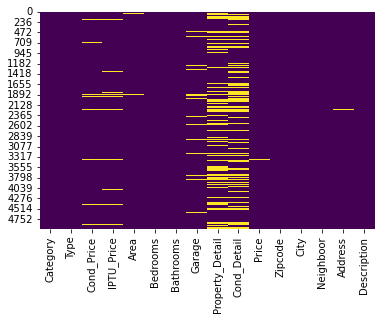

In [6]:
#Let's analyze the distribution of missing values
sns.heatmap(df_Properties2.isnull(),cbar=False,cmap='viridis')

### 3.3 Dealing with missing values

<AxesSubplot:>

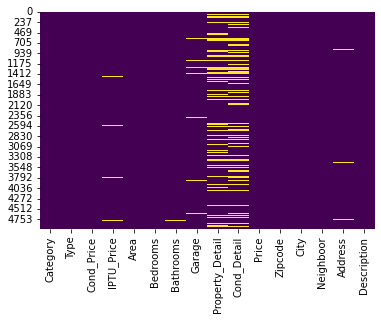

In [7]:
#For a good analysis of the houses I believe some very important information is the Price and the Area
#So let's remove the lines with null information in price and area
df_Properties2 = df_Properties2[~df_Properties2['Price'].isnull()]
df_Properties2 = df_Properties2[~df_Properties2['Area'].isnull()]
sns.heatmap(df_Properties2.isnull(),cbar=False,cmap='viridis')

In [8]:
#Let's analyze the columns IPTU price that is relative to the value of tax over property that need be paid every year to the goverment
df_Properties2['IPTU_Price'].value_counts()

R$ 0        3787
R$ 1          80
R$ 1.200      27
R$ 800        26
R$ 600        21
            ... 
R$ 1.498       1
R$ 652         1
R$ 67          1
R$ 1.130       1
R$ 716         1
Name: IPTU_Price, Length: 389, dtype: int64

In [9]:
#Let's analyze the columns Cond_Price that is relative to the value of monthly payment for the use of the amendments
#In the properties that are located inside home condominium
df_Properties2['Cond_Price'].value_counts()

R$ 0          1853
R$ 700          96
R$ 1.100        84
R$ 600          83
R$ 500          79
              ... 
R$ 2.104         1
R$ 1.420         1
R$ 2.161         1
R$ 996           1
R$ 110.000       1
Name: Cond_Price, Length: 584, dtype: int64

In [10]:
#We saw that IPTU_Price and Cond_Price has a lot of zero values, for the IPTU column it is really strange, because every property must pay it
#But for Cond_Price, there is some properties that are not located inside a condominium and do not need pay it
#So let's check how these zero values are distributed
df_Properties2[df_Properties2['Cond_Price'] == 'R$ 0'].groupby('Type')['Price'].count()

Type
Venda - apartamento cobertura          14
Venda - apartamento padrão            960
Venda - casa em condominio fechado     59
Venda - casa em rua pública           805
Venda - casa em vila                    2
Venda - loft/studio                    13
Name: Price, dtype: int64

In [11]:
#After evaluation only 'Type' values 'Venda - casa em rua pública' and 'Venda - casa em vila' could not have the Cond_Price, but we saw too many others also with R$ 0
#So in this case it is better drop Cond_Price and also IPTU_Price for our analysis
#Too many zero values, it is better we drop this column
df_Properties2.drop(['Cond_Price'
                     ,'IPTU_Price'
                     ],axis=1, inplace=True)

In [12]:
df_Properties2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4862 entries, 0 to 4982
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         4862 non-null   object
 1   Type             4862 non-null   object
 2   Area             4862 non-null   object
 3   Bedrooms         4862 non-null   object
 4   Bathrooms        4853 non-null   object
 5   Garage           4701 non-null   object
 6   Property_Detail  3607 non-null   object
 7   Cond_Detail      3502 non-null   object
 8   Price            4862 non-null   object
 9   Zipcode          4862 non-null   int64 
 10  City             4862 non-null   object
 11  Neighboor        4862 non-null   object
 12  Address          4819 non-null   object
 13  Description      4862 non-null   object
dtypes: int64(1), object(13)
memory usage: 569.8+ KB


In [13]:
#Let's check now about the Address column null values
df_Properties2[df_Properties2['Address'].isnull()]

,Category,Type,Area,Bedrooms,Bathrooms,Garage,Property_Detail,Cond_Detail,Price,Zipcode,City,Neighboor,Address,Description
179,Casas,Venda - casa em rua pública,80m²,2,2,2,"Área de serviço, Quarto de serviço","Segurança 24h, Área murada, Permitido animais",R$ 145.000,60888000,Fortaleza,Pedras,NaN,"CASAS NOVAS PRONTAS PARA MORAR , SAIA JÁ DO AL..."
202,Apartamentos,Venda - apartamento padrão,105m²,3,3,2,"Churrasqueira, Piscina, Academia, Varanda, Áre...","Condomínio fechado, Piscina, Academia, Salão d...",R$ 515.000,60325440,Fortaleza,Monte Castelo,NaN,Código do anúncio: 1IUF242\n\nApartamento com ...
324,Casas,Venda - casa em condominio fechado,115m²,3,4,3,"Churrasqueira, Porteiro 24h, Ar condicionado, ...","Permitido animais, Academia, Condomínio fechad...",R$ 459.000,60832650,Fortaleza,Lagoa Redonda,NaN,Código do anúncio: BABMTK\n\nDuplex no condomí...
416,Apartamentos,Venda - apartamento padrão,110m²,3,3,2,NaN,NaN,R$ 390.000,60170241,Fortaleza,Dionisio Torres,NaN,Código do anúncio: 51a_2-615924\n\nApartamento...
417,Casas,Venda - casa em rua pública,95m²,2,1,NaN,NaN,NaN,R$ 130.000,60822462,Fortaleza,Cidade dos Funcionários,NaN,Código do anúncio: SLLOMA18 (85)... ver número...
433,Casas,Venda - casa em rua pública,65m²,1,1,0,Área de serviço,NaN,R$ 42.000,60865080,Fortaleza,Jangurussu,NaN,Casa à venda em rua pública.\nRua Rita de Arru...
497,Apartamentos,Venda - apartamento cobertura,72m²,3,1,1,"Armários embutidos, Área de serviço, Armários ...","Condomínio fechado, Segurança 24h, Portaria, P...",R$ 175.000,60763820,Fortaleza,Novo Mondubim,NaN,"Vendo um lindo apartamento, 3 quartos, sala, c..."
757,Apartamentos,Venda - apartamento padrão,48m²,2,1,1,Churrasqueira,"Condomínio fechado, Segurança 24h, Portaria, P...",R$ 68.000,60861630,Fortaleza,Passaré,NaN,Repasso um apartamento localizado na avenida J...
854,Apartamentos,Venda - apartamento padrão,60m²,3,2,1,Piscina,"Piscina, Condomínio fechado, Segurança 24h",R$ 210.000,60425720,Fortaleza,Damas,NaN,Código do anúncio: AV 488\n\nExcelente apartam...
1015,Apartamentos,Venda - apartamento padrão,138m²,3,3,2,Salão de festas,"Salão de festas, Elevador",R$ 380.000,60175005,Fortaleza,Papicu,NaN,Código do anúncio: JEIP9O\n\nEd. San Silvestre...


In [14]:
lst_CEP_null_address = list(df_Properties2[df_Properties2['Address'].isnull()]['Zipcode'].unique())

In [15]:
#Use a API to try get information about the address from the Zipcode
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
lst_CEP = {}
for item in lst_CEP_null_address:
    cep = str(item)
    link = f'https://viacep.com.br/ws/{cep}/json'
    requisicao = requests.get(link,headers=headers) 
    if requisicao.status_code == 200:
        lst_CEP[cep] = requisicao.json()
        time.sleep(2)
        print(item)

60888000
60325440
60832650
60170241
60822462
60865080
60763820
60861630
60425720
60175005
60060090
60810250
60874637
60761135
60510107
60110301
60833096
60175110
60190000
60811110
60526375
60811020
60000000
60190070
60830690
60711455
60175190
60874626
60880000
60425552
60832360
60110260
60170040
60825270
60135410
60810000


In [16]:
df_CEP_data = pd.DataFrame(lst_CEP)
df_CEP_data

,60888000,60325440,60832650,60170241,60822462,60865080,60763820,60861630,60425720,60175005,...,60175190,60874626,60880000,60425552,60832360,60110260,60170040,60825270,60135410,60810000
erro,true,NaN,NaN,NaN,NaN,true,true,true,true,NaN,...,NaN,true,true,true,true,true,NaN,true,NaN,true
cep,NaN,60325-440,60832-650,60170-241,60822-462,NaN,NaN,NaN,NaN,60175-005,...,60175-190,NaN,NaN,NaN,NaN,NaN,60170-040,NaN,60135-410,NaN
logradouro,NaN,Rua Conrado Cabral,Rua Antônio Pompil,Rua Coronel Linhares,Rua Doutor José Furtado,NaN,NaN,NaN,NaN,Rua Joaquim Lima,...,Rua Nossa Senhora da Saúde,NaN,NaN,NaN,NaN,NaN,Rua Leonardo Mota,NaN,Rua Dom Expedito Lopes,NaN
complemento,NaN,até 409/410,,de 1991/1992 ao fim,lado par,NaN,NaN,NaN,NaN,até 99997/99998,...,,NaN,NaN,NaN,NaN,NaN,até 899/900,NaN,,NaN
bairro,NaN,Monte Castelo,Lagoa Redonda,Dionisio Torres,Cidade dos Funcionários,NaN,NaN,NaN,NaN,Papicu,...,Mucuripe,NaN,NaN,NaN,NaN,NaN,Meireles,NaN,Dionisio Torres,NaN
localidade,NaN,Fortaleza,Fortaleza,Fortaleza,Fortaleza,NaN,NaN,NaN,NaN,Fortaleza,...,Fortaleza,NaN,NaN,NaN,NaN,NaN,Fortaleza,NaN,Fortaleza,NaN
uf,NaN,CE,CE,CE,CE,NaN,NaN,NaN,NaN,CE,...,CE,NaN,NaN,NaN,NaN,NaN,CE,NaN,CE,NaN
ibge,NaN,2304400,2304400,2304400,2304400,NaN,NaN,NaN,NaN,2304400,...,2304400,NaN,NaN,NaN,NaN,NaN,2304400,NaN,2304400,NaN
gia,NaN,,,,,NaN,NaN,NaN,NaN,,...,,NaN,NaN,NaN,NaN,NaN,,NaN,,NaN
ddd,NaN,85,85,85,85,NaN,NaN,NaN,NaN,85,...,85,NaN,NaN,NaN,NaN,NaN,85,NaN,85,NaN


In [17]:
#Let's invert this dataframe
df_CEP_data = df_CEP_data.T.reset_index()
df_CEP_data

,index,erro,cep,logradouro,complemento,bairro,localidade,uf,ibge,gia,ddd,siafi
0,60888000,true,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60325440,NaN,60325-440,Rua Conrado Cabral,até 409/410,Monte Castelo,Fortaleza,CE,2304400,,85,1389
2,60832650,NaN,60832-650,Rua Antônio Pompil,,Lagoa Redonda,Fortaleza,CE,2304400,,85,1389
3,60170241,NaN,60170-241,Rua Coronel Linhares,de 1991/1992 ao fim,Dionisio Torres,Fortaleza,CE,2304400,,85,1389
4,60822462,NaN,60822-462,Rua Doutor José Furtado,lado par,Cidade dos Funcionários,Fortaleza,CE,2304400,,85,1389
5,60865080,true,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,60763820,true,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,60861630,true,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,60425720,true,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,60175005,NaN,60175-005,Rua Joaquim Lima,até 99997/99998,Papicu,Fortaleza,CE,2304400,,85,1389


In [18]:
df_CEP_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        36 non-null     object
 1   erro         17 non-null     object
 2   cep          19 non-null     object
 3   logradouro   19 non-null     object
 4   complemento  19 non-null     object
 5   bairro       19 non-null     object
 6   localidade   19 non-null     object
 7   uf           19 non-null     object
 8   ibge         19 non-null     object
 9   gia          19 non-null     object
 10  ddd          19 non-null     object
 11  siafi        19 non-null     object
dtypes: object(12)
memory usage: 3.5+ KB


In [19]:
#Now let's add the 'logradouro' to the 'address' of the ones that has valids Zipcodes and has returned some value from the API
#Let's create a function that we can apply to each row in the dataset
def update_address_by_zipcode(row,cep_dataframe):
    if pd.isnull(row['Address']):
        if str(row['Zipcode']) in list(cep_dataframe['index']):
            row['Address'] = cep_dataframe[cep_dataframe['index'] == str(row['Zipcode'])]['logradouro']
    return row

In [20]:
df_Properties3 = df_Properties2.apply(lambda row: update_address_by_zipcode(row, df_CEP_data[df_CEP_data['erro'].notnull()]), axis=1)
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4862 entries, 0 to 4982
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         4862 non-null   object
 1   Type             4862 non-null   object
 2   Area             4862 non-null   object
 3   Bedrooms         4862 non-null   object
 4   Bathrooms        4853 non-null   object
 5   Garage           4701 non-null   object
 6   Property_Detail  3607 non-null   object
 7   Cond_Detail      3502 non-null   object
 8   Price            4862 non-null   object
 9   Zipcode          4862 non-null   int64 
 10  City             4862 non-null   object
 11  Neighboor        4862 non-null   object
 12  Address          4842 non-null   object
 13  Description      4862 non-null   object
dtypes: int64(1), object(13)
memory usage: 569.8+ KB


In [21]:
#So we recovered 23 address using the API to get information from CEP, still missing 20 addresses, let's remove these lines, 
#because later we will use the adress to collect the latitude and longitude to be able to do some plots in map
df_Properties3 = df_Properties3[df_Properties3['Address'].notnull()]
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4842 entries, 0 to 4982
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         4842 non-null   object
 1   Type             4842 non-null   object
 2   Area             4842 non-null   object
 3   Bedrooms         4842 non-null   object
 4   Bathrooms        4833 non-null   object
 5   Garage           4683 non-null   object
 6   Property_Detail  3592 non-null   object
 7   Cond_Detail      3487 non-null   object
 8   Price            4842 non-null   object
 9   Zipcode          4842 non-null   int64 
 10  City             4842 non-null   object
 11  Neighboor        4842 non-null   object
 12  Address          4842 non-null   object
 13  Description      4842 non-null   object
dtypes: int64(1), object(13)
memory usage: 567.4+ KB


In [22]:
#Now we only have 4 columns with missing values, for the column Bathroom, let's have a looks in the properties that is missing this information,
#It would be common to have at least 1 bathroom in the property.
df_Properties3[df_Properties3['Bathrooms'].isnull()]

,Category,Type,Area,Bedrooms,Bathrooms,Garage,Property_Detail,Cond_Detail,Price,Zipcode,City,Neighboor,Address,Description
94,Apartamentos,Venda - apartamento padrão,360m²,0,NaN,NaN,NaN,NaN,R$ 26.000,60760325,Fortaleza,Planalto Ayrton Senna,Rua Silvia Santos,"Vendo lote na praia do Balbino, excelente prai..."
258,Apartamentos,Venda - apartamento padrão,248m²,4,NaN,5 ou mais,Varanda,NaN,R$ 2.359.000,60810145,Fortaleza,Guararapes,Avenida Chanceler Edson Queiroz,Apartamento no Melhor condomínio do bairro Gua...
348,Casas,Venda - casa em rua pública,210m²,4,NaN,3,"Área de serviço, Armários na cozinha, Armários...",NaN,R$ 450.000,60320330,Fortaleza,São Gerardo,Rua Carmem Cenira,Vendo uma casa localizada na Rua Carmem Cenira...
1105,Apartamentos,Venda - apartamento padrão,122m²,3,NaN,2,"Armários embutidos, Armários na cozinha, Ar co...","Condomínio fechado, Elevador, Segurança 24h, P...",R$ 249.000,60160230,Fortaleza,Meireles,Avenida Dom Luís - lado ímpar,Rua Mestre Jerônimo 233\nMucuripe\n\n 5 minuto...
1314,Casas,Venda - casa em rua pública,23m²,1,NaN,0,Quarto de serviço,NaN,R$ 220.000,60863750,Fortaleza,Barroso,Rua 16 (Cj João Paulo II),Vendo uma vila de casa por 220.000 interessado...
1776,Apartamentos,Venda - apartamento padrão,164m²,3,NaN,2,"Área de serviço, Armários na cozinha, Varanda,...","Elevador, Portaria, Permitido animais, Salão d...",R$ 925.000,60170320,Fortaleza,Meireles,Rua Coronel Jucá - até 429/430,"03 suítes, cozinha com armários, sala grande, ..."
3150,Casas,Venda - casa em condominio fechado,353m²,4,NaN,4,Área de serviço,"Condomínio fechado, Segurança 24h, Área murada...",R$ 2.250.000,60055270,Fortaleza,José Bonifácio,Vila São Jorge,Vendo casa em condomínio fechado ( AZUR) no Eu...
4541,Apartamentos,Venda - apartamento padrão,79m²,3,NaN,2,"Área de serviço, Armários embutidos, Armários ...","Condomínio fechado, Elevador, Segurança 24h, P...",R$ 560.000,60170265,Fortaleza,Meireles,Avenida Senador Virgílio Távora - até 889 - la...,"REF: 687149\n\nExcelente apartamento de 79,37 ..."
4781,Apartamentos,Venda - apartamento padrão,63m²,2,NaN,1,"Área de serviço, Armários embutidos, Armários ...","Condomínio fechado, Elevador, Segurança 24h, P...",R$ 699.000,60192340,Fortaleza,Cocó,Rua Doutor Batista de Oliveira - de 731/732 ao...,Edifício de alto padrão. \n\nEntre em contato ...


In [23]:
#Looks like it is reasonable we set the value 1 for bathroom for these properties
df_Properties3['Bathrooms'] = df_Properties3['Bathrooms'].apply(lambda x: x if pd.notnull(x) else '1')
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4842 entries, 0 to 4982
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         4842 non-null   object
 1   Type             4842 non-null   object
 2   Area             4842 non-null   object
 3   Bedrooms         4842 non-null   object
 4   Bathrooms        4842 non-null   object
 5   Garage           4683 non-null   object
 6   Property_Detail  3592 non-null   object
 7   Cond_Detail      3487 non-null   object
 8   Price            4842 non-null   object
 9   Zipcode          4842 non-null   int64 
 10  City             4842 non-null   object
 11  Neighboor        4842 non-null   object
 12  Address          4842 non-null   object
 13  Description      4842 non-null   object
dtypes: int64(1), object(13)
memory usage: 567.4+ KB


In [24]:
#For garage let's apply zero
df_Properties3['Garage'] = df_Properties3['Garage'].apply(lambda x: x if pd.notnull(x) else '0')
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4842 entries, 0 to 4982
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         4842 non-null   object
 1   Type             4842 non-null   object
 2   Area             4842 non-null   object
 3   Bedrooms         4842 non-null   object
 4   Bathrooms        4842 non-null   object
 5   Garage           4842 non-null   object
 6   Property_Detail  3592 non-null   object
 7   Cond_Detail      3487 non-null   object
 8   Price            4842 non-null   object
 9   Zipcode          4842 non-null   int64 
 10  City             4842 non-null   object
 11  Neighboor        4842 non-null   object
 12  Address          4842 non-null   object
 13  Description      4842 non-null   object
dtypes: int64(1), object(13)
memory usage: 567.4+ KB


In [25]:
#Now only the columns Property_Detail and Cond_Detail has missing values, these columns are about amendments in the property and in the condominium, I took a look in the website
#to check the options available, the options available are shown in the picture below. For these columns we will create a columns for each item and encode the values of these columns
#for the properties with null values we will consider there is no amendments for this case study.

![OLX_details.png](./Resources/OLX_datails.png)

In [26]:
#To ensure we have all the values we can iterate over the dataframe and evaluate the values
set_prop_details = set()
set_cond_details = set()
for row in df_Properties3.itertuples():
    if pd.notnull(row.Property_Detail):
        lst_details = row.Property_Detail.split(',')
        for item in lst_details:
            item = item.strip()
            set_prop_details.add(item)
    if pd.notnull(row.Cond_Detail):
        lst_details = row.Cond_Detail.split(',')
        for item in lst_details:
            item = item.strip()
            set_cond_details.add(item)
print(set_prop_details)
print(set_cond_details)

{'Armários na cozinha', 'Quarto de serviço', 'Varanda', 'Academia', 'Ar condicionado', 'Área de serviço', 'Salão de festas', 'Porteiro 24h', 'Churrasqueira', 'Armários embutidos', 'Piscina', 'Mobiliado'}
{'Elevador', 'Permitido animais', 'Segurança 24h', 'Portaria', 'Academia', 'Condomínio fechado', 'Salão de festas', 'Portão eletrônico', 'Área murada', 'Piscina'}


In [27]:
#Let's create a function to encode the columns
def encode_details(row):
    row['c_Elevador'] = 0
    row['c_Portaria'] = 0
    row['c_Piscina'] = 0
    row['c_Portao_eletronico'] = 0 
    row['c_Condominio_fechado'] = 0  
    row['c_Segurança_24h'] = 0 
    row['c_Permitido_animais'] = 0  
    row['c_Area_murada'] = 0 
    row['c_Academia'] = 0  
    row['c_Salao_de_festas'] = 0 
    if pd.notnull(row['Cond_Detail']):
        lst_cond_details = list(row['Cond_Detail'].split(','))
        for item in lst_cond_details:
            if item.strip() == 'Elevador':  
                row['c_Elevador'] = 1
            if item.strip() == 'Portaria':
                row['c_Portaria'] = 1
            if item.strip() == 'Piscina':
                row['c_Piscina'] = 1
            if item.strip() == 'Portão eletrônico':
                row['c_Portao_eletronico'] = 1 
            if item.strip() == 'Condomínio fechado':
                row['c_Condominio_fechado'] = 1
            if item.strip() == 'Segurança 24h':
                row['c_Segurança_24h'] = 1
            if item.strip() == 'Permitido animais':
                row['c_Permitido_animais'] = 1
            if item.strip() == 'Área murada':
                row['c_Area_murada'] = 1
            if item.strip() == 'Academia':
                row['c_Academia'] = 1
            if item.strip() == 'Salão de festas':
                row['c_Salao_de_festas'] = 1 
    row['p_Porteiro_24h'] = 0
    row['p_Churrasqueira'] = 0
    row['p_Piscina'] = 0
    row['p_Armarios_embutidos'] = 0
    row['p_Ar_condicionado'] = 0
    row['p_Quarto_de_servico'] = 0
    row['p_Varanda'] = 0
    row['p_Armarios_na_cozinha'] = 0
    row['p_Academia'] = 0
    row['p_Area_de_servico'] = 0
    row['p_Mobiliado'] = 0
    row['p_Salao_de_festas'] = 0
    if pd.notnull(row['Property_Detail']):
        lst_prop_details = list(row['Property_Detail'].split(','))
        for item in lst_prop_details:
            if item.strip() == 'Porteiro 24h':
                row['p_Porteiro_24h'] = 1
            if item.strip() == 'Churrasqueira':                
                row['p_Churrasqueira'] = 1
            if item.strip() == 'Piscina':                
                row['p_Piscina'] = 1
            if item.strip() == 'Armários embutidos':                
                row['p_Armarios_embutidos'] = 1
            if item.strip() == 'Ar condicionado':                
                row['p_Ar_condicionado'] = 1
            if item.strip() == 'Quarto de serviço':                
                row['p_Quarto_de_servico'] = 1
            if item.strip() == 'Varanda':                
                row['p_Varanda'] = 1
            if item.strip() == 'Armários na cozinha':                
                row['p_Armarios_na_cozinha'] = 1
            if item.strip() == 'Academia':                
                row['p_Academia'] = 1
            if item.strip() == 'Área de serviço':                
                row['p_Area_de_servico'] = 1
            if item.strip() == 'Mobiliado':                
                row['p_Mobiliado'] = 1
            if item.strip() == 'Salão de festas':                
                row['p_Salao_de_festas'] = 1
    return row

In [28]:
df_Properties3 = df_Properties3.apply(encode_details,axis=1)
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4842 entries, 0 to 4982
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Category               4842 non-null   object
 1   Type                   4842 non-null   object
 2   Area                   4842 non-null   object
 3   Bedrooms               4842 non-null   object
 4   Bathrooms              4842 non-null   object
 5   Garage                 4842 non-null   object
 6   Property_Detail        3592 non-null   object
 7   Cond_Detail            3487 non-null   object
 8   Price                  4842 non-null   object
 9   Zipcode                4842 non-null   int64 
 10  City                   4842 non-null   object
 11  Neighboor              4842 non-null   object
 12  Address                4842 non-null   object
 13  Description            4842 non-null   object
 14  c_Elevador             4842 non-null   int64 
 15  c_Portaria           

In [29]:
#Now we can drop the columns Cond_Detail and Property_Detail
df_Properties3.drop(['Cond_Detail'
                     ,'Property_Detail'
                     ],axis=1, inplace=True)
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4842 entries, 0 to 4982
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Category               4842 non-null   object
 1   Type                   4842 non-null   object
 2   Area                   4842 non-null   object
 3   Bedrooms               4842 non-null   object
 4   Bathrooms              4842 non-null   object
 5   Garage                 4842 non-null   object
 6   Price                  4842 non-null   object
 7   Zipcode                4842 non-null   int64 
 8   City                   4842 non-null   object
 9   Neighboor              4842 non-null   object
 10  Address                4842 non-null   object
 11  Description            4842 non-null   object
 12  c_Elevador             4842 non-null   int64 
 13  c_Portaria             4842 non-null   int64 
 14  c_Piscina              4842 non-null   int64 
 15  c_Portao_eletronico  

<AxesSubplot:>

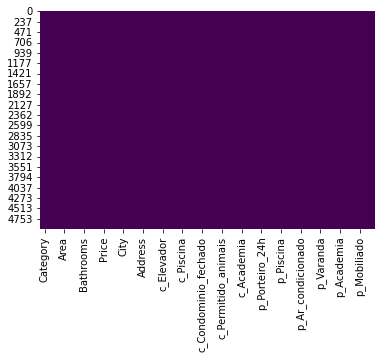

In [30]:
#Now we have all the columns with the same quantity of non-null values
sns.heatmap(df_Properties3.isnull(),cbar=False,cmap='viridis')

In [31]:
#Now let's transform the Price in a numeric column
df_Properties3['Price_Value'] = pd.to_numeric(df_Properties3["Price"].str.split(expand = True)[1].str.replace('.',''))
df_Properties3.head(10)

,Category,Type,Area,Bedrooms,Bathrooms,Garage,Price,Zipcode,City,Neighboor,...,p_Armarios_embutidos,p_Ar_condicionado,p_Quarto_de_servico,p_Varanda,p_Armarios_na_cozinha,p_Academia,p_Area_de_servico,p_Mobiliado,p_Salao_de_festas,Price_Value
0,Apartamentos,Venda - apartamento padrão,110m²,3,4,2,R$ 690.000,60110370,Fortaleza,Meireles,...,0,1,0,1,0,1,0,1,0,690000
1,Apartamentos,Venda - apartamento padrão,54m²,2,2,2,R$ 499.000,60812260,Fortaleza,Edson Queiroz,...,0,1,0,0,0,0,0,0,0,499000
2,Apartamentos,Venda - apartamento padrão,82m²,3,3,2,R$ 650.000,60810220,Fortaleza,Engenheiro Luciano Cavalcante,...,0,0,0,0,0,0,1,0,0,650000
3,Casas,Venda - casa em rua pública,145m²,3,2,0,R$ 275.000,60050040,Fortaleza,Centro,...,0,0,0,0,0,0,0,0,0,275000
4,Apartamentos,Venda - apartamento padrão,58m²,2,2,1,R$ 450.000,60824030,Fortaleza,Parque Iracema,...,0,0,0,0,0,0,0,0,0,450000
5,Apartamentos,Venda - apartamento padrão,56m²,2,2,1,R$ 570.000,60115080,Fortaleza,Meireles,...,0,0,0,0,0,0,0,0,0,570000
6,Apartamentos,Venda - apartamento padrão,53m²,2,2,1,R$ 449.000,60822365,Fortaleza,Cambeba,...,0,0,0,0,0,1,0,0,0,449000
7,Apartamentos,Venda - apartamento padrão,100m²,3,4,2,R$ 950.000,60192035,Fortaleza,Cocó,...,0,0,0,0,0,0,0,0,0,950000
8,Apartamentos,Venda - apartamento padrão,152m²,3,4,3,R$ 1.341.236,60811310,Fortaleza,Engenheiro Luciano Cavalcante,...,0,0,0,0,0,1,1,0,0,1341236
9,Casas,Venda - casa em condominio fechado,98m²,3,2,2,R$ 580.000,60833365,Fortaleza,Sapiranga-Coité,...,0,0,0,0,0,0,1,0,0,580000


In [32]:
#Now let's transform the Area in a numeric column
df_Properties3["Area_value"] = pd.to_numeric(df_Properties3["Area"].str.replace('m²',''))
df_Properties3.head(10)

,Category,Type,Area,Bedrooms,Bathrooms,Garage,Price,Zipcode,City,Neighboor,...,p_Ar_condicionado,p_Quarto_de_servico,p_Varanda,p_Armarios_na_cozinha,p_Academia,p_Area_de_servico,p_Mobiliado,p_Salao_de_festas,Price_Value,Area_value
0,Apartamentos,Venda - apartamento padrão,110m²,3,4,2,R$ 690.000,60110370,Fortaleza,Meireles,...,1,0,1,0,1,0,1,0,690000,110
1,Apartamentos,Venda - apartamento padrão,54m²,2,2,2,R$ 499.000,60812260,Fortaleza,Edson Queiroz,...,1,0,0,0,0,0,0,0,499000,54
2,Apartamentos,Venda - apartamento padrão,82m²,3,3,2,R$ 650.000,60810220,Fortaleza,Engenheiro Luciano Cavalcante,...,0,0,0,0,0,1,0,0,650000,82
3,Casas,Venda - casa em rua pública,145m²,3,2,0,R$ 275.000,60050040,Fortaleza,Centro,...,0,0,0,0,0,0,0,0,275000,145
4,Apartamentos,Venda - apartamento padrão,58m²,2,2,1,R$ 450.000,60824030,Fortaleza,Parque Iracema,...,0,0,0,0,0,0,0,0,450000,58
5,Apartamentos,Venda - apartamento padrão,56m²,2,2,1,R$ 570.000,60115080,Fortaleza,Meireles,...,0,0,0,0,0,0,0,0,570000,56
6,Apartamentos,Venda - apartamento padrão,53m²,2,2,1,R$ 449.000,60822365,Fortaleza,Cambeba,...,0,0,0,0,1,0,0,0,449000,53
7,Apartamentos,Venda - apartamento padrão,100m²,3,4,2,R$ 950.000,60192035,Fortaleza,Cocó,...,0,0,0,0,0,0,0,0,950000,100
8,Apartamentos,Venda - apartamento padrão,152m²,3,4,3,R$ 1.341.236,60811310,Fortaleza,Engenheiro Luciano Cavalcante,...,0,0,0,0,1,1,0,0,1341236,152
9,Casas,Venda - casa em condominio fechado,98m²,3,2,2,R$ 580.000,60833365,Fortaleza,Sapiranga-Coité,...,0,0,0,0,0,1,0,0,580000,98


In [33]:
df_Properties3["Bathrooms"].value_counts()

2            1497
3            1110
4             907
5 ou mais     751
1             574
0               3
Name: Bathrooms, dtype: int64

In [34]:
#Looking to the columns Bathrooms and Garage we noted they have the same format as the Bedroom column
#So we are creating new columns with numeric values
df_Properties3['Bedrooms_qty'] = pd.to_numeric(df_Properties3["Bedrooms"].str.replace(' ou mais',''))
df_Properties3['Bathrooms_qty'] = pd.to_numeric(df_Properties3["Bathrooms"].str.replace(' ou mais',''))
df_Properties3['Garage_qty'] = pd.to_numeric(df_Properties3["Garage"].str.replace(' ou mais',''))
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4842 entries, 0 to 4982
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Category               4842 non-null   object
 1   Type                   4842 non-null   object
 2   Area                   4842 non-null   object
 3   Bedrooms               4842 non-null   object
 4   Bathrooms              4842 non-null   object
 5   Garage                 4842 non-null   object
 6   Price                  4842 non-null   object
 7   Zipcode                4842 non-null   int64 
 8   City                   4842 non-null   object
 9   Neighboor              4842 non-null   object
 10  Address                4842 non-null   object
 11  Description            4842 non-null   object
 12  c_Elevador             4842 non-null   int64 
 13  c_Portaria             4842 non-null   int64 
 14  c_Piscina              4842 non-null   int64 
 15  c_Portao_eletronico  

In [35]:
#Now we can drop the columns that we transformed in numeric columns
df_Properties3.drop(['Price'
                     ,'Area'
                     ,'Bedrooms'
                     ,'Bathrooms'
                     ,'Garage'
                     ],axis=1, inplace=True)

In [36]:
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4842 entries, 0 to 4982
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Category               4842 non-null   object
 1   Type                   4842 non-null   object
 2   Zipcode                4842 non-null   int64 
 3   City                   4842 non-null   object
 4   Neighboor              4842 non-null   object
 5   Address                4842 non-null   object
 6   Description            4842 non-null   object
 7   c_Elevador             4842 non-null   int64 
 8   c_Portaria             4842 non-null   int64 
 9   c_Piscina              4842 non-null   int64 
 10  c_Portao_eletronico    4842 non-null   int64 
 11  c_Condominio_fechado   4842 non-null   int64 
 12  c_Segurança_24h        4842 non-null   int64 
 13  c_Permitido_animais    4842 non-null   int64 
 14  c_Area_murada          4842 non-null   int64 
 15  c_Academia           

In [53]:
df_Properties3.describe()

,Zipcode,c_Elevador,c_Portaria,c_Piscina,c_Portao_eletronico,c_Condominio_fechado,c_Segurança_24h,c_Permitido_animais,c_Area_murada,c_Academia,...,p_Armarios_na_cozinha,p_Academia,p_Area_de_servico,p_Mobiliado,p_Salao_de_festas,Price_Value,Area_value,Bedrooms_qty,Bathrooms_qty,Garage_qty
count,4.842000e+03,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,...,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4.842000e+03,4842.000000,4842.000000,4842.000000,4842.000000
mean,6.042641e+07,0.434118,0.242255,0.456836,0.035523,0.401074,0.064849,0.317637,0.004957,0.262701,...,0.074349,0.245147,0.352127,0.134449,0.007228,8.033121e+05,139.312061,2.968815,2.949401,2.144362
std,3.181336e+05,0.495692,0.428492,0.498185,0.185115,0.490167,0.246285,0.465606,0.070236,0.440147,...,0.262366,0.430219,0.477683,0.341169,0.084721,1.058775e+06,135.085245,0.809249,1.262705,1.180655
min,6.000000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e+01,0.000000,0.000000,0.000000,0.000000
25%,6.016006e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.050000e+05,70.000000,3.000000,2.000000,1.000000
50%,6.019226e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.216670e+05,107.000000,3.000000,3.000000,2.000000
75%,6.081226e+07,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,8.500000e+05,162.000000,3.000000,4.000000,3.000000
max,6.088800e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.399000e+07,4205.000000,5.000000,5.000000,5.000000


In [45]:
numeric_columns = []
for item in df_Properties3.columns:
    if df_Properties3[item].dtype == 'int64':
        numeric_columns.append(item)
print(numeric_columns)

['Zipcode', 'c_Elevador', 'c_Portaria', 'c_Piscina', 'c_Portao_eletronico', 'c_Condominio_fechado', 'c_Segurança_24h', 'c_Permitido_animais', 'c_Area_murada', 'c_Academia', 'c_Salao_de_festas', 'p_Porteiro_24h', 'p_Churrasqueira', 'p_Piscina', 'p_Armarios_embutidos', 'p_Ar_condicionado', 'p_Quarto_de_servico', 'p_Varanda', 'p_Armarios_na_cozinha', 'p_Academia', 'p_Area_de_servico', 'p_Mobiliado', 'p_Salao_de_festas', 'Price_Value', 'Area_value', 'Bedrooms_qty', 'Bathrooms_qty', 'Garage_qty']


In [89]:
def plot_hist_dist(columns, df):
    for item in columns:
        mu, std = norm.fit(df[item])
        plt.hist(df[item], density=True, alpha=0.6)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2)
        title = item + " Skew: {:.2f} and Kurtosis: {:.2f}".format(df[item].skew()
                                                                   ,df[item].kurtosis())
        plt.title(title) 
        plt.show()

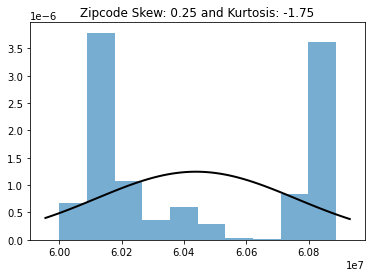

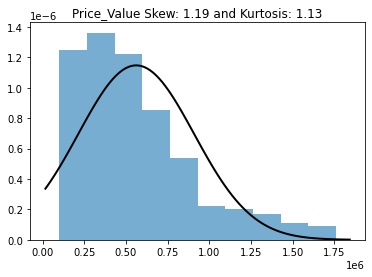

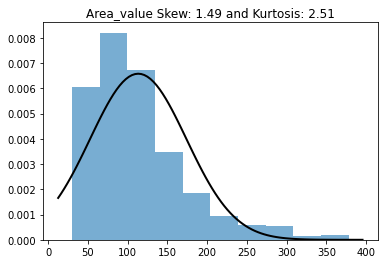

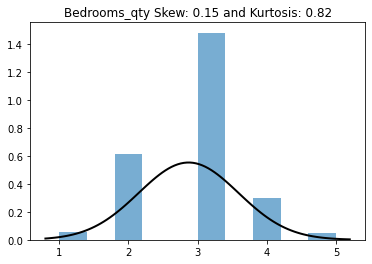

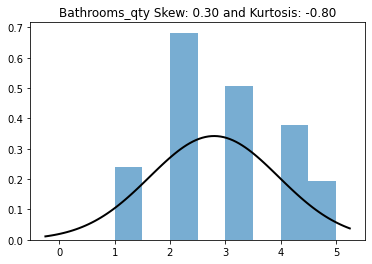

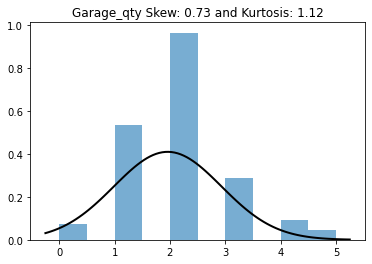

In [90]:
for item in numeric_columns:
    if ('c_' not in item) & ('p_' not in item):
        plot_hist_dist([item],df_Properties3)

<AxesSubplot:>

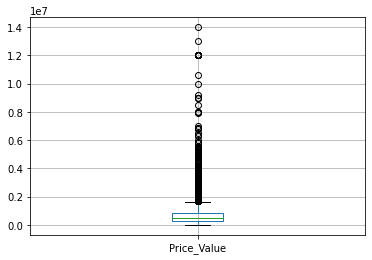

In [65]:
#Price Value and Area Value has high skew we need check it
df_Properties3.boxplot(column = 'Price_Value')

In [79]:
#We have too many outliers we need evaluate better the values
df_Properties3[['Price_Value','Area_value']].sort_values(by='Price_Value').head(30)

,Price_Value,Area_value
2750,80,3
2739,90,120
2260,260,140
415,495,145
561,2300,40
46,8000,20
2645,14500,0
4357,15000,66
1437,19000,270
4581,19000,100


In [81]:
#For our study and for the porpose of my research, I am not looking for properties 
#less than 100k and also not over 2M so i will remove these lines
df_Properties3 = df_Properties3[(df_Properties3['Price_Value'] >= 100000) & (df_Properties3['Price_Value'] <= 2000000)]
#Let's look the high values now
df_Properties3.describe()

,Zipcode,c_Elevador,c_Portaria,c_Piscina,c_Portao_eletronico,c_Condominio_fechado,c_Segurança_24h,c_Permitido_animais,c_Area_murada,c_Academia,...,p_Armarios_na_cozinha,p_Academia,p_Area_de_servico,p_Mobiliado,p_Salao_de_festas,Price_Value,Area_value,Bedrooms_qty,Bathrooms_qty,Garage_qty
count,4.404000e+03,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,...,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4.404000e+03,4404.000000,4404.000000,4404.000000,4404.000000
mean,6.043763e+07,0.436421,0.243188,0.448683,0.037466,0.405995,0.065168,0.323569,0.004541,0.255223,...,0.076748,0.239101,0.353088,0.137375,0.007493,5.946599e+05,123.921208,2.909628,2.849909,2.008856
std,3.196912e+05,0.495998,0.429056,0.497416,0.189922,0.491139,0.246850,0.467891,0.067244,0.436036,...,0.266222,0.426583,0.477984,0.344282,0.086248,3.943220e+05,109.946348,0.766377,1.196728,1.044616
min,6.000000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05,0.000000,0.000000,0.000000,0.000000
25%,6.016004e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000e+05,68.000000,2.000000,2.000000,1.000000
50%,6.032027e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.950000e+05,100.000000,3.000000,3.000000,2.000000
75%,6.081368e+07,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,7.500000e+05,146.000000,3.000000,4.000000,2.000000
max,6.088800e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000e+06,4205.000000,5.000000,5.000000,5.000000


In [82]:
#Let's look now the area_value
df_Properties3[['Price_Value','Area_value']].sort_values(by='Area_value').head(30)

,Price_Value,Area_value
2144,649000,0
4726,250000,0
423,230000,0
1643,500000,10
3218,170000,10
2585,175000,10
3235,380000,10
4824,175000,10
1999,125000,10
1983,185000,10


In [83]:
#For our study and for the porpose of my research, I am not looking for properties 
#with area less than 30 square meters
df_Properties3 = df_Properties3[(df_Properties3['Area_value'] >= 30)]
df_Properties3.describe()

,Zipcode,c_Elevador,c_Portaria,c_Piscina,c_Portao_eletronico,c_Condominio_fechado,c_Segurança_24h,c_Permitido_animais,c_Area_murada,c_Academia,...,p_Armarios_na_cozinha,p_Academia,p_Area_de_servico,p_Mobiliado,p_Salao_de_festas,Price_Value,Area_value,Bedrooms_qty,Bathrooms_qty,Garage_qty
count,4.370000e+03,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,...,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4.370000e+03,4370.000000,4370.000000,4370.000000,4370.000000
mean,6.043721e+07,0.438215,0.244165,0.449657,0.037757,0.407780,0.065217,0.325400,0.004577,0.255835,...,0.076888,0.239588,0.355149,0.137300,0.007551,5.967282e+05,124.775057,2.913272,2.858124,2.019222
std,3.196196e+05,0.496225,0.429640,0.497516,0.190631,0.491478,0.246937,0.468578,0.067504,0.436380,...,0.266444,0.426881,0.478613,0.344203,0.086580,3.943292e+05,109.942220,0.761293,1.195670,1.036569
min,6.000000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05,30.000000,0.000000,0.000000,0.000000
25%,6.016004e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.050000e+05,69.000000,2.000000,2.000000,1.000000
50%,6.032024e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05,102.000000,3.000000,3.000000,2.000000
75%,6.081368e+07,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,7.500000e+05,146.000000,3.000000,4.000000,2.000000
max,6.088800e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000e+06,4205.000000,5.000000,5.000000,5.000000


In [85]:
#Let's work now to remove the outliers
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [86]:
df_Properties3 = remove_outliers(df_Properties3,['Price_Value','Area_value'],3)
df_Properties3.describe()

Working on column: Price_Value
Working on column: Area_value


,Zipcode,c_Elevador,c_Portaria,c_Piscina,c_Portao_eletronico,c_Condominio_fechado,c_Segurança_24h,c_Permitido_animais,c_Area_murada,c_Academia,...,p_Armarios_na_cozinha,p_Academia,p_Area_de_servico,p_Mobiliado,p_Salao_de_festas,Price_Value,Area_value,Bedrooms_qty,Bathrooms_qty,Garage_qty
count,4.201000e+03,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,...,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4.201000e+03,4201.000000,4201.000000,4201.000000,4201.000000
mean,6.043865e+07,0.442514,0.247084,0.447274,0.037610,0.413949,0.067365,0.325875,0.004761,0.257558,...,0.076172,0.241371,0.353249,0.135920,0.007855,5.616936e+05,113.299453,2.869793,2.798857,1.959533
std,3.203747e+05,0.496743,0.431367,0.497271,0.190274,0.492598,0.250683,0.468757,0.068842,0.437341,...,0.265305,0.427966,0.478036,0.342744,0.088292,3.476833e+05,60.656749,0.721404,1.166296,0.972860
min,6.000000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05,30.000000,1.000000,0.000000,0.000000
25%,6.016004e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.990000e+05,68.000000,2.000000,2.000000,1.000000
50%,6.032027e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.800000e+05,100.000000,3.000000,3.000000,2.000000
75%,6.081372e+07,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,7.300000e+05,139.000000,3.000000,4.000000,2.000000
max,6.088800e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.760000e+06,378.000000,5.000000,5.000000,5.000000


<AxesSubplot:>

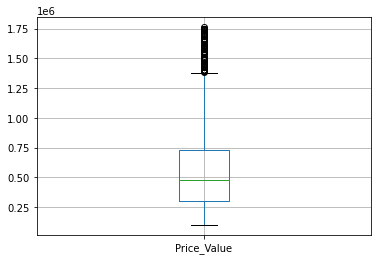

In [87]:
df_Properties3.boxplot(column = 'Price_Value')

<AxesSubplot:>

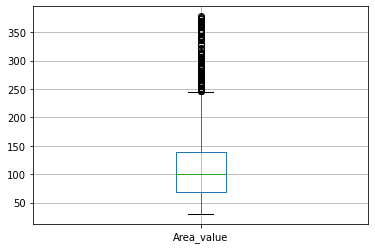

In [88]:
df_Properties3.boxplot(column = 'Area_value')

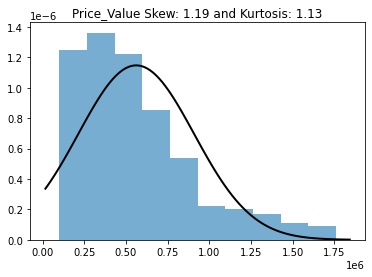

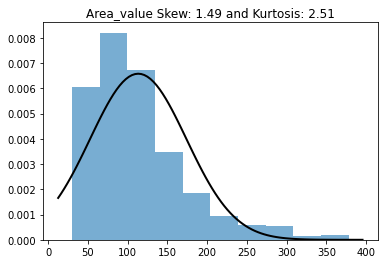

In [91]:
plot_hist_dist(['Price_Value','Area_value'],df_Properties3)

In [92]:
#Let's create a new column with the price per square meter
df_Properties3['square_meter_price'] = df_Properties3['Price_Value']/df_Properties3['Area_value']

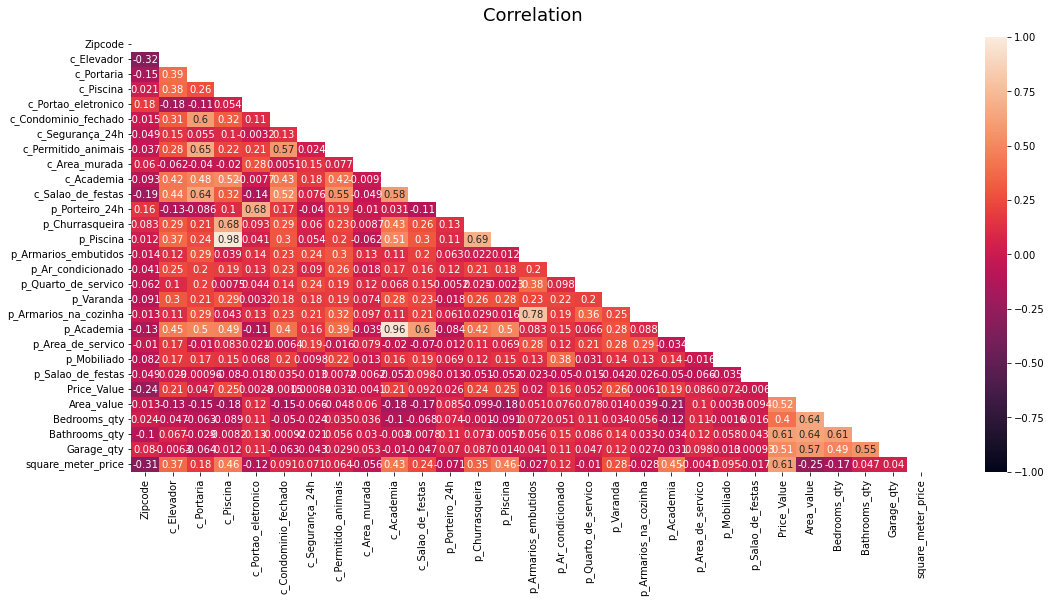

In [93]:
#Let's check the columns correlation
plt.figure(figsize=(18, 8))
mask = np.triu(np.ones_like(df_Properties3.corr(), dtype=bool))
heatmap = sns.heatmap(df_Properties3.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation', fontdict={'fontsize':18}, pad=16);

In [111]:
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4201 entries, 0 to 4982
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Category               4201 non-null   object 
 1   Type                   4201 non-null   object 
 2   Zipcode                4201 non-null   int64  
 3   City                   4201 non-null   object 
 4   Neighboor              4201 non-null   object 
 5   Address                4201 non-null   object 
 6   Description            4201 non-null   object 
 7   c_Elevador             4201 non-null   int64  
 8   c_Portaria             4201 non-null   int64  
 9   c_Piscina              4201 non-null   int64  
 10  c_Portao_eletronico    4201 non-null   int64  
 11  c_Condominio_fechado   4201 non-null   int64  
 12  c_Segurança_24h        4201 non-null   int64  
 13  c_Permitido_animais    4201 non-null   int64  
 14  c_Area_murada          4201 non-null   int64  
 15  c_Ac

graph for Category: total = 2


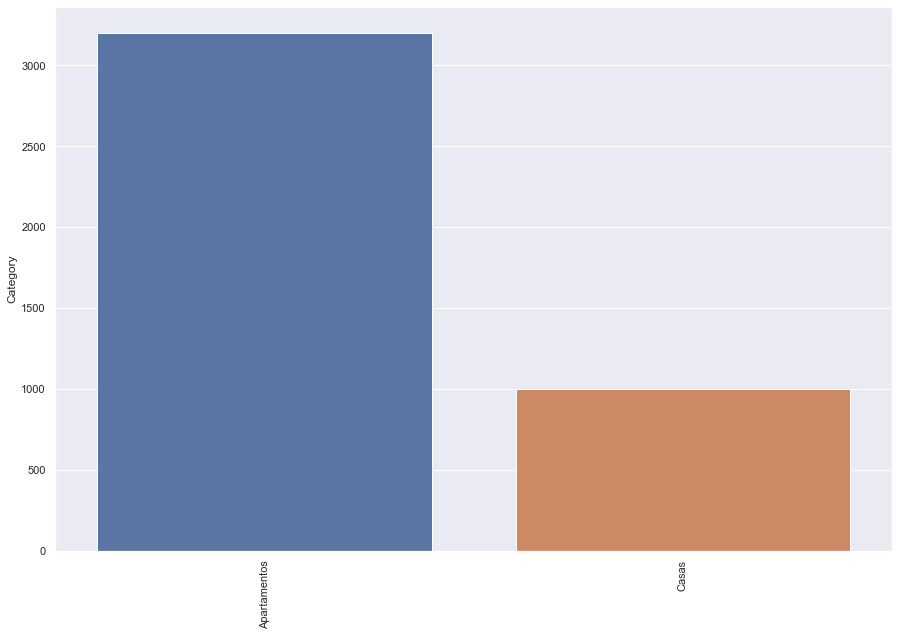

graph for Type: total = 8


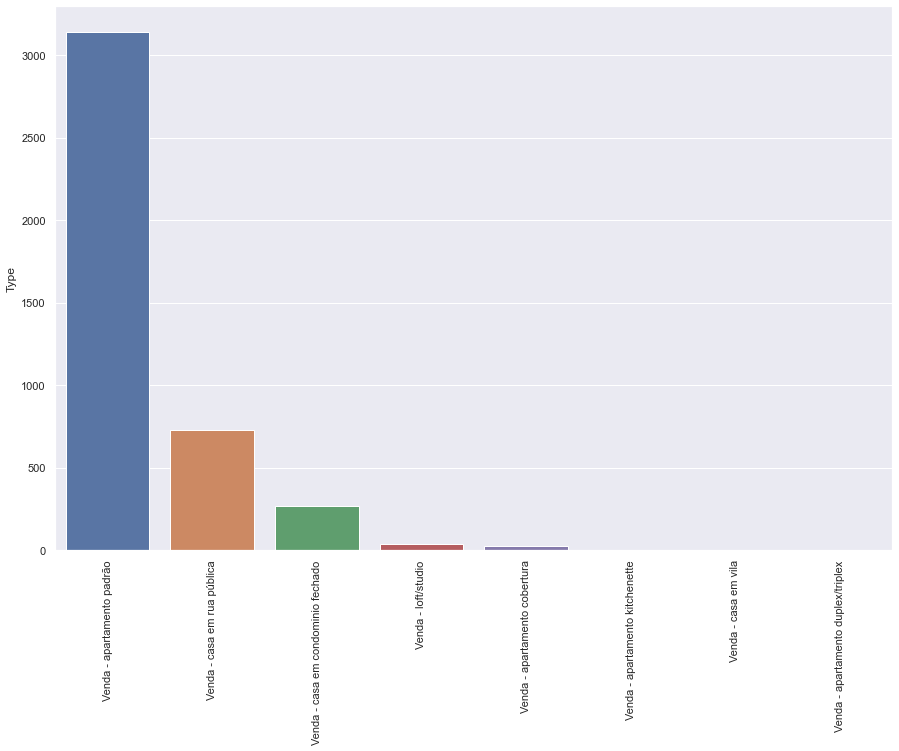

graph for Neighboor: total = 30


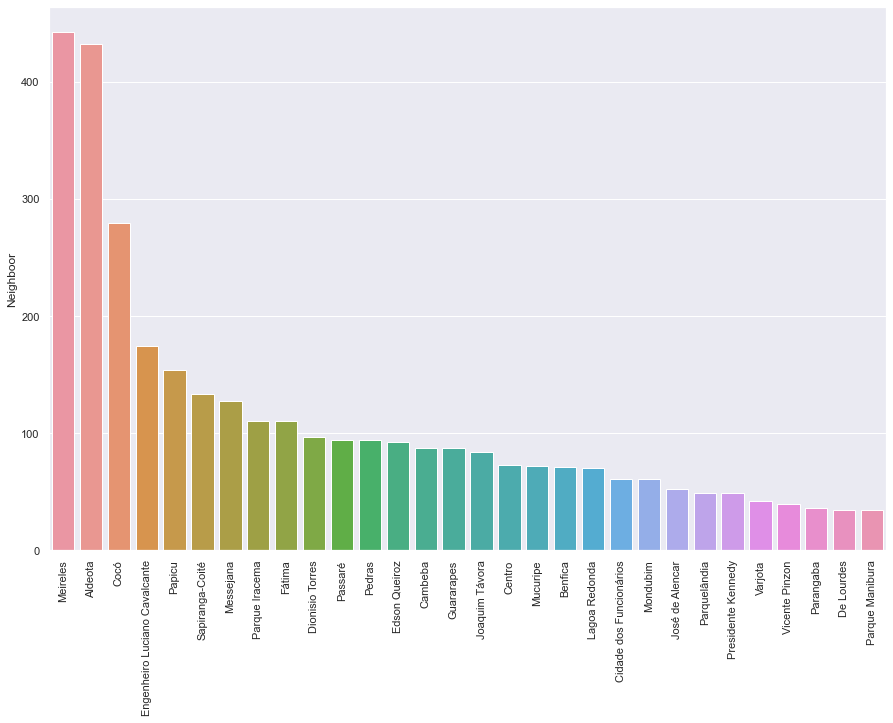

In [118]:
#Let's do some analysis
sns.set(rc={'figure.figsize':(15,10)})
for i in df_Properties3[['Category','Type','Neighboor']].columns:
    cat_num = df_Properties3[i].value_counts()[:30]
    print("graph for %s: total = %d" % (i, len(cat_num)))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

In [97]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [103]:
words = " ".join(df_Properties3['Description'])

In [104]:
def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('portuguese'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered

In [109]:
words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

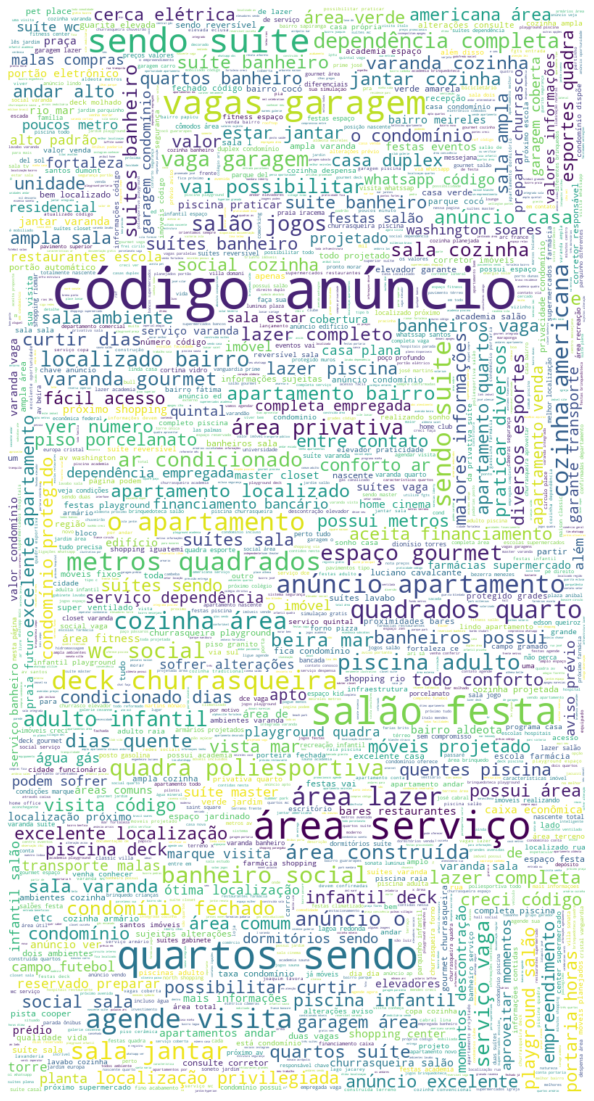

In [110]:
plt.figure(figsize=[20,20])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

In [37]:
#Evaluating the columns Category and Type, looks like Type is a subcategory of each Category
df_Properties2.groupby(['Category','Type'])['Price'].count()

Category      Type                              
Apartamentos  Venda - apartamento cobertura           52
              Venda - apartamento duplex/triplex       2
              Venda - apartamento kitchenette          4
              Venda - apartamento padrão            3550
              Venda - loft/studio                     39
Casas         Venda - casa em condominio fechado     299
              Venda - casa em rua pública            912
              Venda - casa em vila                     4
Name: Price, dtype: int64

<AxesSubplot:>

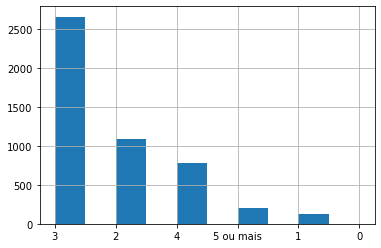

In [38]:
#So we can see the Type values in the Category 'Apartamentos' are different from the Type values in the category 'Casas' 
#so for future more deep analysis only the Type column is enogh
#Lets check the values of Bedrooms, Bathrooms and Garage Columns
df_Properties2.Bedrooms.hist()

<AxesSubplot:>

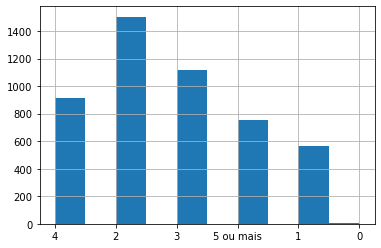

In [39]:
df_Properties2.Bathrooms.hist()

<AxesSubplot:>

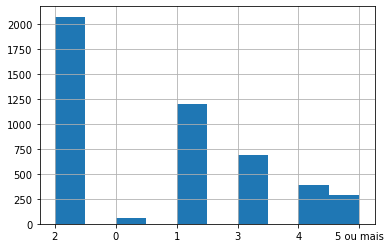

In [40]:
df_Properties2.Garage.hist()

In [41]:
#Let's look to the Category Column
df_Properties3['Category'].value_counts()

Apartamentos    3631
Casas           1211
Name: Category, dtype: int64

In [42]:
#Let's look to the Type Column
df_Properties3['Type'].value_counts()

Venda - apartamento padrão            3534
Venda - casa em rua pública            911
Venda - casa em condominio fechado     296
Venda - apartamento cobertura           52
Venda - loft/studio                     39
Venda - apartamento kitchenette          4
Venda - casa em vila                     4
Venda - apartamento duplex/triplex       2
Name: Type, dtype: int64

In [43]:
#looks like Type column is a subset of the Category column so lets check
df_Properties3.groupby(['Category','Type'])['Zipcode'].count()

Category      Type                              
Apartamentos  Venda - apartamento cobertura           52
              Venda - apartamento duplex/triplex       2
              Venda - apartamento kitchenette          4
              Venda - apartamento padrão            3534
              Venda - loft/studio                     39
Casas         Venda - casa em condominio fechado     296
              Venda - casa em rua pública            911
              Venda - casa em vila                     4
Name: Zipcode, dtype: int64

<AxesSubplot:title={'center':'Quantity of properties for sale by city'}, xlabel='City', ylabel='Quantity of properties for sale'>

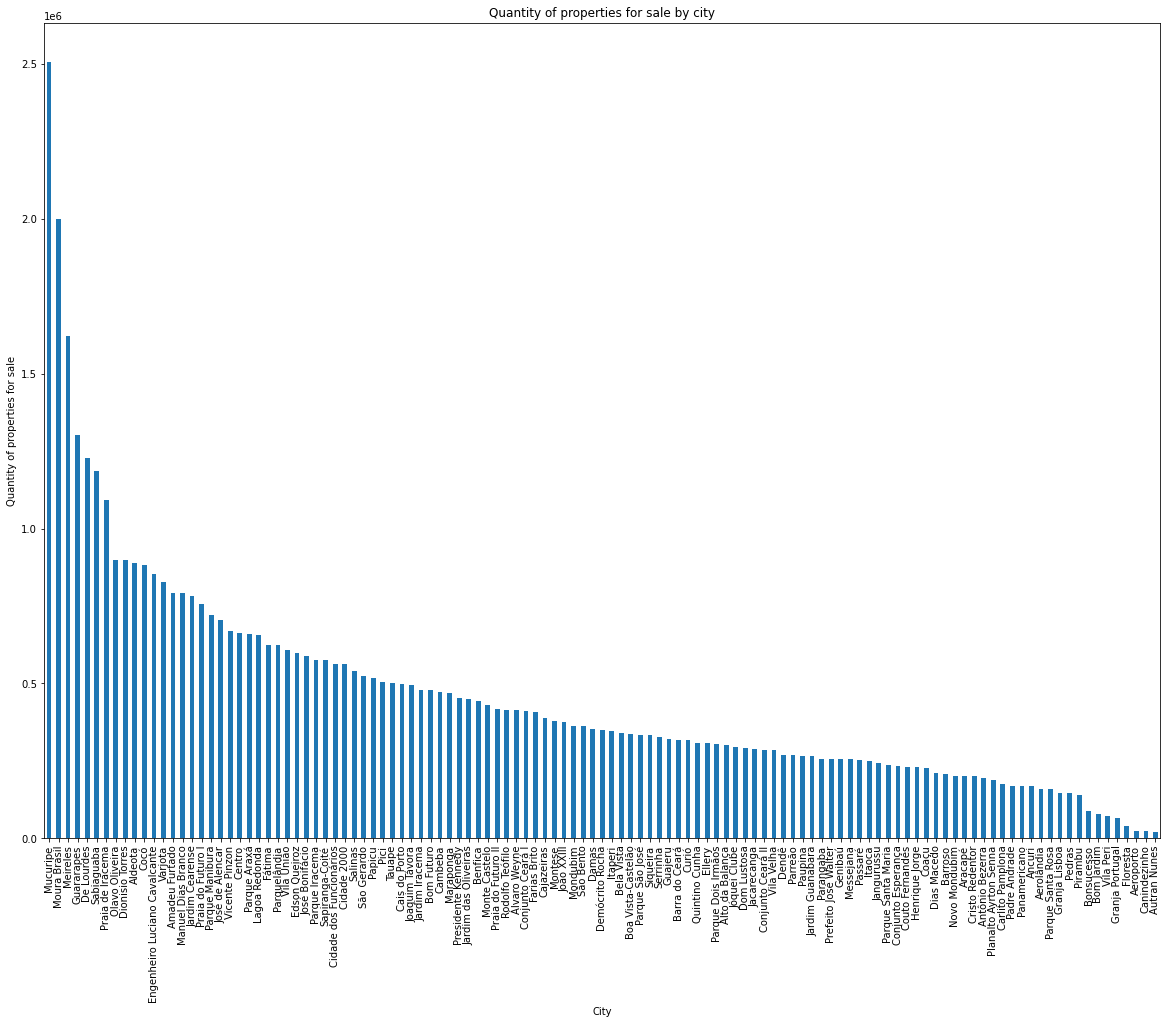

In [44]:
#Quantity of properties for sale by city
df_Properties3.groupby('Neighboor')['Price_Value'].mean().sort_values(ascending=False).plot.bar(title = 'Quantity of properties for sale by city'
                                                                                                  ,xlabel = 'City'
                                                                                                  ,ylabel='Quantity of properties for sale'
                                                                                                  ,figsize=(20,15))